In [1]:
#!pip install numpy
#!pip install scipy
#!pip install matplotlib

import timeit
from multiprocessing import Pool
from typing import List, Any
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Non parallel bootstrapping
## Create a sample of normal distribution
sample_normal = np.random.normal(5, 1, 100)
real_mean = sample_normal.mean()

## Generate 100 samples with replacement
samples_100 = [np.random.choice(sample_normal, 100) for x in range(0, 100)]
samples_1000 = [np.random.choice(sample_normal, 100) for x in range(0, 1000)]

## Estimate the mean for each sample
mean_samples_100 = np.array([x.mean() for x in samples_100])
mean_samples_1000 = np.array([x.mean() for x in samples_1000])

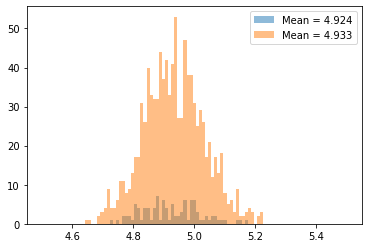

In [11]:
bins = np.linspace(4.5, 5.5, 100)

plt.hist(mean_samples_100, bins, alpha=0.5, label='Mean = ' + str(round(mean_samples_100.mean(), 3)))
plt.hist(mean_samples_1000, bins, alpha=0.5, label='Mean = ' + str(round(mean_samples_1000.mean(), 3)))
plt.legend(loc='upper right')
plt.show()

In [3]:
from math import factorial
factorial(100)

93326215443944152681699238856266700490715968264381621468592963895217599993229915608941463976156518286253697920827223758251185210916864000000000000000000000000

In [12]:
# Non-parallel
## Function for samples
def sampling(x, samples = 100, sample_size = 0):
    """
    The sampling function takes three main arguments (for now):
    x = object to extract samples. Preferably a numpy array.
    samples = number of samples to make. Default is 100.
    sample_size = size of each sample extracted from x.
    RETURN 
    returns a list of samples (numpy arrays) 
    """
    if sample_size == 0:
        sample_size = len(x)
    
    x = np.array(x)
    
    samples = [np.random.choice(x, sample_size) for _ in range(samples)]
    
    return samples

## Function for applying function
def bootstrap(x: list, func):
    """
    The boostrap function takes two argument:
    x = a list created by the sampling function
    func = the function to apply (ex. mean)
    RETURN
    returns a list of results from the applied
    function to each sample of x
    """
    return [func(z) for z in x]

# Parallel
## Function for samples
def sample(sizes = 100):
    return np.random.choice(sample_normal, sizes)

def par_sampling(x, samples = 100, sample_size = 0, workers = 4):
    """
    The sampling function takes three main arguments (for now):
    x = object to extract samples. Preferably a numpy array.
    samples = number of samples to make. Default is 100.
    sample_size = size of each sample extracted from x.
    RETURN 
    returns a list of samples (numpy arrays) 
    """
    from multiprocessing import Pool
    if sample_size == 0:
        sample_size = len(x)
    
    x = np.array(x)
    
    with Pool(processes = workers) as pool:
        samples = pool.map_async(sample, [100 for _ in range(samples)])
    return samples

## Function for applying function
def par_bootstrap(x: list, func, workers = 4):
    """
    The boostrap function takes two argument:
    x = a list created by the sampling function
    func = the function to apply (ex. mean)
    RETURN
    returns a list of results from the applied
    function to each sample of x
    """
    from multiprocessing import Pool
    with Pool(processes = workers) as pool:
        result = pool.map(func, x)
    return result



In [26]:
samples_100 = sampling(sample_normal, 100, 100)
result_100 = bootstrap(samples_100, np.mean)

In [7]:
## Bootstrap class
class Bootstrap:
    def __init__(self, x = np.array(100), size = 100, samples_size = 100):
        self.x = x
        self.size = size
        self.samples_size = samples_size
        self.samples = [np.random.choice(x, samples_size) for i in range(1, size)]
        
    def mean(self):
        self.means = np.array([x.mean() for x in self.samples])
        
    def std(self):
        self.stds = np.array([x.std() for x in self.samples])
        

In [5]:
%%timeit
test = Bootstrap(sample_normal, size = 1000, samples_size = 100)

111 ms ± 126 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
test.mean()

In [ ]:
plt.hist(test.means, bins = 25)

In [12]:
## Parallel Bootstrap class
def samp(x, samples_size):
    return np.random.choice(x, samples_size)

class ParBootstrap:
    def __init__(self, x = np.array(100), size = 100, samples_size = 100, workers = 3):
        self.x = x
        self.size = size
        self.samples_size = samples_size
        self.workers = workers
    
    def sampling(self):
        with Pool(processes = self.workers) as pool:
            res = pool.starmap(samp, [(self.x, self.samples_size) for _ in range(self.size)])
        self.samples = res
        
    def mean(self):
        with Pool(processes = self.workers) as pool:
            res = pool.map(np.mean, self.samples)
        self.means = res
        
    def std(self):
        with Pool(processes = self.workers) as pool:
            res = pool.map(np.std, self.samples)
        self.stds = res
        
        



In [13]:
test_p = ParBootstrap(sample_normal, size = 1000, samples_size = 100, workers = 3)
test_p.sampling()

In [9]:
test_p.sampling()

In [10]:
test_p.mean()

(array([ 12.,  42.,  72., 134., 204., 231., 153.,  96.,  50.,   6.]),
 array([4.66106056, 4.72141396, 4.78176736, 4.84212076, 4.90247416,
        4.96282756, 5.02318096, 5.08353436, 5.14388776, 5.20424116,
        5.26459456]),
 <a list of 10 Patch objects>)

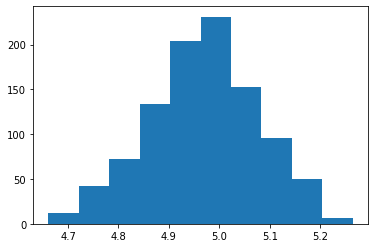

In [11]:
plt.hist(test_p.means)

In [19]:
benchmark = []

s = '''
sample_normal = np.random.normal(5, 1, 1000)
test = Bootstrap(sample_normal, 100000, 100)
test.mean()
'''

setup = '''
import numpy as np
from __main__ import Bootstrap
'''


s_par = '''
sample_normal = np.random.normal(5, 1, 1000)
test_p = ParBootstrap(sample_normal, size = 100000, samples_size = 100, workers = 2)
test_p.sampling()
test_p.mean()
'''

setup_par = '''
from multiprocessing import Pool
import numpy as np
from __main__ import ParBootstrap
'''

benchmark.append(timeit.Timer(stmt = s, setup = setup).timeit(10))
benchmark.append(timeit.Timer(stmt = s_par, setup = setup_par).timeit(10))

In [20]:
benchmark

[12.559468209999977, 21.510267692999946]

In [13]:
benchmark = []

s = '''
sample_normal = np.random.normal(5, 1, 1000)
test = sampling(sample_normal, 1000, 100)
means_b = bootstrap(test, np.mean)
'''

setup = '''
import numpy as np
from __main__ import sampling, bootstrap
'''


s_par = '''
sample_normal = np.random.normal(5, 1, 1000)
test_p = par_sampling(sample_normal, 1000, 100, workers = 4)
means_b = par_bootstrap(test_p, np.mean)
'''

setup_par = '''
from multiprocessing import Pool
import numpy as np
from __main__ import par_sampling, par_bootstrap
'''

benchmark.append(timeit.Timer(stmt = s, setup = setup).timeit(10))
benchmark.append(timeit.Timer(stmt = s_par, setup = setup_par).timeit(10))

benchmark

TypeError: 'MapResult' object is not iterable